In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp



In [2]:
model = tf.keras.models.load_model('models/FFNN_fs8.h5')
ffnn_do = tf.keras.models.load_model('models/FFNN_fs8.h5')

In [3]:
file = 'data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
z = data.values[:,0]
y = data.values[:,1:]
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
zinv = scalerz.transform(z.reshape(-1,1))
# zor = scalerz.inverse_transform(z.reshape(-1,1))

## First, we predict at the same redshifts than within the original dataset.

In [4]:
r = scalerz.transform(zinv.reshape(-1, 1))
predfs8 = model.predict(r)

In [5]:
# save fake data
mockfs8_ffnn = np.concatenate((z.reshape(len(z), 1), predfs8), axis=1)
np.savetxt("fs8_ffnn_mock.dat",mockfs8_ffnn, delimiter=" ")

(-0.01, 2.044)

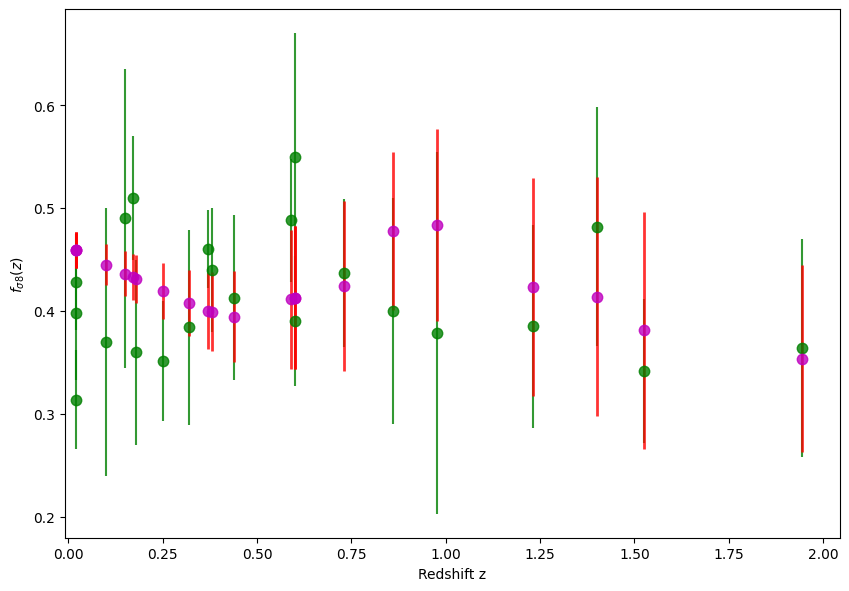

In [6]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.8)

plt.errorbar(z, predfs8[:,0], predfs8[:,1], markersize=15, fmt='.', 
             ecolor='r', capthick=2, elinewidth=2, alpha=0.8, c='m')

plt.xlabel("Redshift z")

plt.ylabel("$f_{\sigma8}(z)$")
plt.xlim(0-0.01, max(z)+0.1)
# plt.yscale('log')

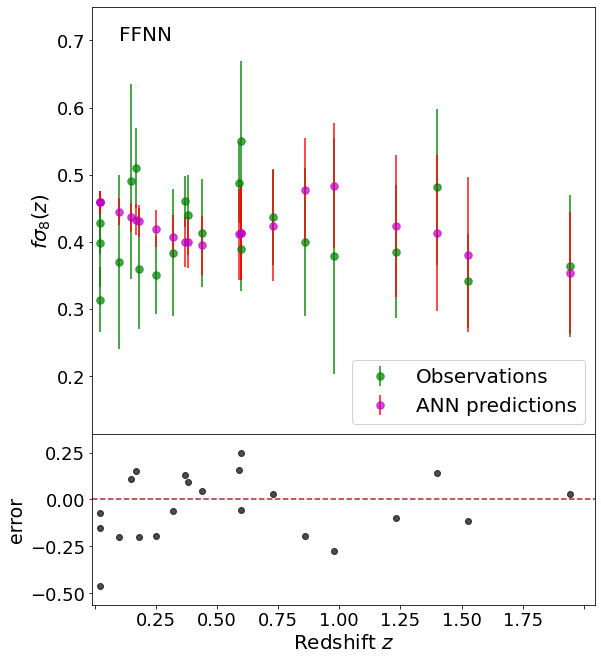

In [36]:
fig, axs = plt.subplots(2,1,figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

# axs[0].figure(figsize=(10, 7), dpi=100)
axs[0].errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)
axs[0].errorbar(z, predfs8[:,0], predfs8[:,1], markersize=15, fmt='.', label='ANN predictions',
                 ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m')


axs[0].text(0.1, 0.7, 'FFNN', fontsize=20)
axs[0].legend(fontsize=20, loc='lower right', framealpha=0.9, ncol=1)
# axs[0].set_xticks([])

axs[0].set_ylabel("$f{\sigma_8}(z)$", fontsize=20)
axs[0].set_xlim(-0.01, max(z)+0.1)
axs[0].set_ylim(min(y[:,0])-0.2, max(y[:,0])+0.2)


fs8diff = np.subtract(y[:,0], predfs8[:,0].reshape(22,))
fs8errdiff = np.subtract(y[:,1], predfs8[:,1])

# axs[1].errorbar(z, 100*(fs8diff/y[:,0]), yerr=fs8errdiff*100, c='black',  fmt='o',
#                 ecolor='blue', capthick=2, elinewidth=2, alpha=0.7)
axs[1].scatter(z, fs8diff/y[:,0], c='black',  marker='o', alpha=0.7)
# axs[1].plot(z, 100*(fs8diff/y[:,0]) )
# plt.plot()
# axs[1].set_ylabel(r"$\frac{f\sigma8(z)_{obs} - f\sigma8(z)_{ANN}}{f\sigma8(z)_{obs}}$", fontsize=14)
axs[1].set_ylabel("error", fontsize=19)
axs[1].axhline(0, linestyle='--', color='brown')
axs[1].set_xlim(-0.01, max(z)+0.1)

axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)

ylim1 = min(fs8diff/y[:,0])-0.1
ylim2 = max(fs8diff/y[:,0])+0.1
axs[1].set_ylim(ylim1, ylim2)

x_ticks = axs[1].xaxis.get_major_ticks()
x_ticks[1].label1.set_visible(False)
x_ticks[9].label1.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=20)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('fs8sameredshifts_ffnn.png', dpi=100)

In [8]:
test_batch_size = len(z)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = ffnn_do.predict(scalerz.transform(z.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

In [9]:
# save fake data
mocky_mcdo = np.concatenate((prediction_mc_dropout[:,0].reshape(-1,1), sigma.reshape(-1,1)), axis=1)
mockfs8_ffnn_mcdo = np.concatenate((z.reshape(-1,1), mocky_mcdo), axis=1)
np.savetxt("fs8_mcdo_mock.dat",mockfs8_ffnn_mcdo, delimiter=" ")

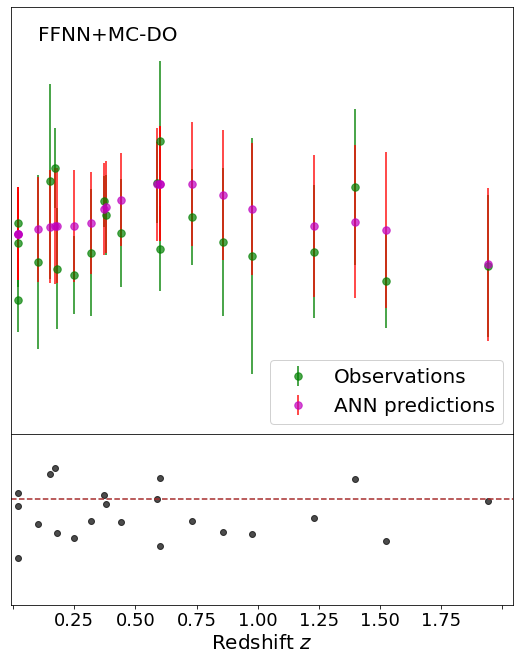

In [35]:
fig, axs = plt.subplots(2,1,figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

axs[0].errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)
axs[0].errorbar(z, prediction_mc_dropout[:,0], yerr=sigma, markersize=15, fmt='.', label='ANN predictions',
                 ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m')


axs[0].text(0.1, 0.7, 'FFNN+MC-DO', fontsize=20)
axs[0].legend(fontsize=20, loc='lower right', framealpha=0.9, ncol=1)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_ylim(min(y[:,0])-0.2, max(y[:,0])+0.2)


# axs[0].set_ylabel("$f\sigma_8(z)$", fontsize=20)
axs[0].set_xlim(-0.01, max(z)+0.1)

fs8diff = np.subtract(y[:,0], prediction_mc_dropout[:,0].reshape(len(z),))
fs8errdiff = np.subtract(y[:,1], sigma)


axs[1].scatter(z, fs8diff/y[:,0], c='black',  marker='o', alpha=0.7)
# axs[1].set_ylabel("error", fontsize=20)
axs[1].axhline(0, linestyle='--', color='brown')
axs[1].set_xlim(-0.01, max(z)+0.1)
axs[1].set_yticks([])
axs[1].set_ylim(ylim1, ylim2)

axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)

x_ticks = axs[1].xaxis.get_major_ticks()
x_ticks[1].label1.set_visible(False)
x_ticks[9].label1.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=20)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    
    ax.label_outer()
    
plt.savefig('fs8sameredshifts_mcdo.png', dpi=100)

### We can add cosmological models to compare the neural network model with the data and the theoretical functions. With many predictions we can obtain a nice $f_\sigma8$ neural reconstruction.

In [11]:
from functools import partial
# Cosmological constants
Om = 0.342
# variance network
s8 = 0.8
h = 1

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return h**2*(Om/a**3+(1.0-Om)*rhow)

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_owacdm(af, w0, wa))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)

In [12]:
z_cosmo = np.linspace(0.0, 4, 100)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []
fowacdm4 = []

# flcdm = []
for zz in z_cosmo:
#     flcdm.append(fs8lcdm(zz))
    flcdm.append(fs8owacdm(zz, w0=-1, wa=0.0))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-0.8, wa=-0.4))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)


In [13]:
ranz = np.linspace(0, 2.5, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

In [14]:
y

array([[0.428 , 0.0465],
       [0.398 , 0.065 ],
       [0.314 , 0.048 ],
       [0.37  , 0.13  ],
       [0.49  , 0.145 ],
       [0.51  , 0.06  ],
       [0.36  , 0.09  ],
       [0.44  , 0.06  ],
       [0.3512, 0.0583],
       [0.4602, 0.0378],
       [0.384 , 0.095 ],
       [0.488 , 0.06  ],
       [0.413 , 0.08  ],
       [0.39  , 0.063 ],
       [0.437 , 0.072 ],
       [0.55  , 0.12  ],
       [0.4   , 0.11  ],
       [0.482 , 0.116 ],
       [0.379 , 0.176 ],
       [0.385 , 0.099 ],
       [0.342 , 0.07  ],
       [0.364 , 0.106 ]])

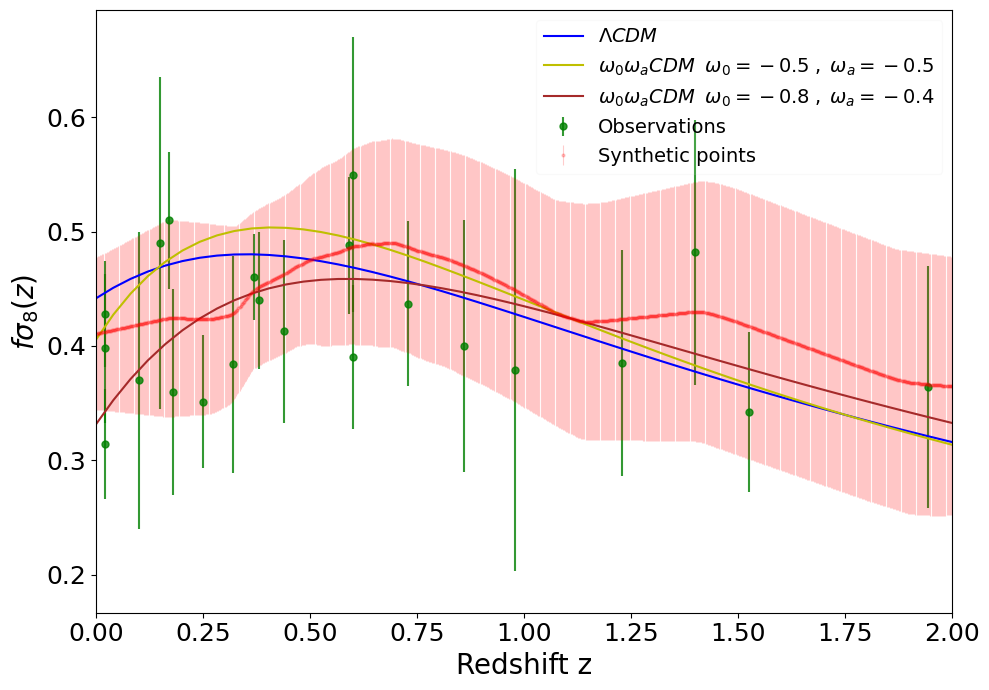

In [30]:
# z = np.linspace(0, 4, 100)
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.2, c='r',)

plt.plot(z_cosmo, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_0 = -1 \;,\; \omega_a=0.5$', c='m')
plt.plot(z_cosmo, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_0 =-0.5 \;,\; \omega_a=-0.5$', c='y')
plt.plot(z_cosmo, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_0 = -0.8 \;,\; \omega_a=-0.4$', c='brown')
# plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("$f\sigma_8(z)$", fontsize=20)
plt.tight_layout()
legend = plt.legend(fontsize=14)
legend.get_frame().set_alpha(0.1)

# plt.savefig("Syntheticfs8b.png",dpi=100)